In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 24524.08it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from rl import RNDIntrinsicReward
import numpy as np

# RND Trial (Can be skipped)

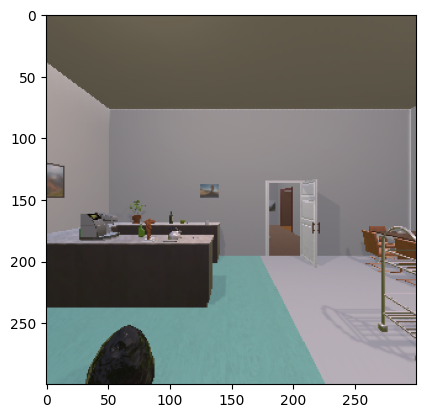

In [4]:
rnd_try = RNDIntrinsicReward()
event = controller.step(
    action="TeleportFull",
    x=spawn["x"],
    y=spawn["y"],
    z=spawn["z"],
    rotation={"x": 0, "y": 90, "z": 0},
    horizon=0,
    standing=True
)
plt.imshow(event.frame)

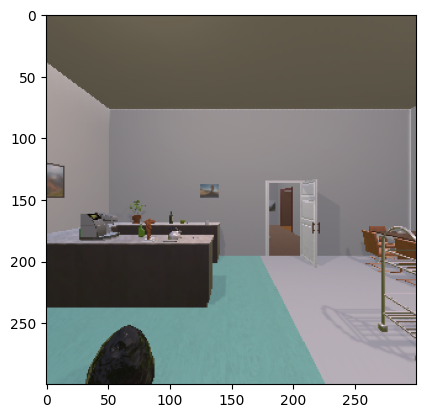

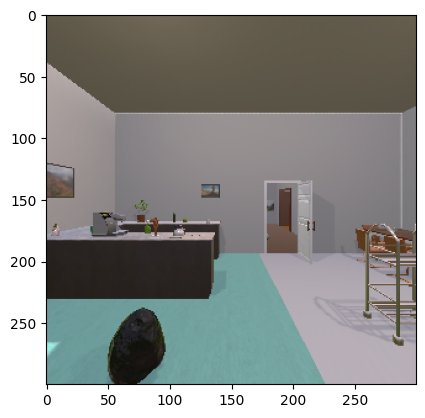

[0.7077688981153927, 0.6869589007283512, 0.6681627746040828, 0.6513654351927917, 0.636009704378654] 0.6076879301382077


In [5]:
event = controller.step("Pass")

rws = []
for i in range(5):
    rw1 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
    rws.append(rw1)
plt.imshow(event.frame)
plt.show()
event = controller.step("MoveBack")
plt.imshow(event.frame)
plt.show()
rw3 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
print(rws, rw3)
# plt.imshow(event.frame.copy())

# Start Training

In [4]:
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, RNDIntrinsicEnv, ClipEnv, CLIPNovelty
from models import Actor, Critic, FrozenResNetEncoder
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS

In [6]:
def train(controller, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            for t in range(1, EPISODE_STEPS + 1):
                obs_t = ppo.obs_from_event(event)  # (C,H,W)
                obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t)
                rewards.append(reward)
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done and np.random.rand() > 0.5:
                    event = teleport(controller)
                    env.reset()
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [8]:
rnd_reward = RNDIntrinsicReward()
rnd_intrinsic_env = RNDIntrinsicEnv(rnd_reward)
rnd_actor_critic = ActorCritic()
buf, rewards = train(ppo, controller, rnd_intrinsic_env, rnd_actor_critic, 1)

TypeError: ActorCritic.__init__() missing 3 required positional arguments: 'encoder', 'actor', and 'critic'

# Final Inference

In [78]:
import matplotlib.pyplot as plt
import numpy as np

n = 120
n_row = 8
positions = []

plt.figure(figsize=(n // n_row, n_row))
event = teleport(controller)

episode_seq = []
for t in range(1, n + 1):
    obs_t = obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
    logits, value = act_and_value(obs_seq)
    dist = torch.distributions.Categorical(logits=logits)
    print(logits.shape)
    print(torch.softmax(logits, dim=0))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0, 4)

    event, reward = rnd_intrinsic_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metadata
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}", fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


TypeError: act_and_value() missing 1 required positional argument: 'actor_critic'

<Figure size 1500x800 with 0 Axes>

In [18]:
controller.stop()

# CLIP Novelty

In [7]:
ENTROPY_COEF = 0.08

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = Actor(FEAT_DIM, NUM_ACTIONS)
critic = Critic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)
buf, rewards = train(controller, ppo, clip_env, clip_actor_critic, 1)

KeyboardInterrupt: 

In [175]:
save_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_clip_embed.pt")

[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_clip_embed.pt


[PPO] Epoch 0: Loss=1.2858, Policy=0.0059, Value=2.5910
[PPO] Epoch 10: Loss=0.2765, Policy=-0.0442, Value=0.6738
[PPO] Epoch 20: Loss=0.0617, Policy=-0.0804, Value=0.3150
[PPO] Epoch 30: Loss=-0.0258, Policy=-0.1009, Value=0.1806
[PPO] Epoch 40: Loss=-0.0717, Policy=-0.1207, Value=0.1275
[PPO] Epoch 50: Loss=-0.0821, Policy=-0.1289, Value=0.1236
[PPO] Epoch 60: Loss=-0.1011, Policy=-0.1256, Value=0.0775
[PPO] Epoch 70: Loss=-0.1128, Policy=-0.1377, Value=0.0791
[PPO] Epoch 80: Loss=-0.1239, Policy=-0.1430, Value=0.0674
[PPO] Epoch 90: Loss=-0.1166, Policy=-0.1426, Value=0.0811
Approx KL Learned: 0.1704757958650589
Update 1/10 — steps: 1024


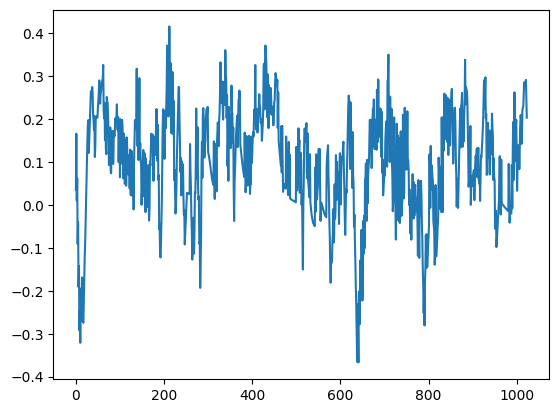

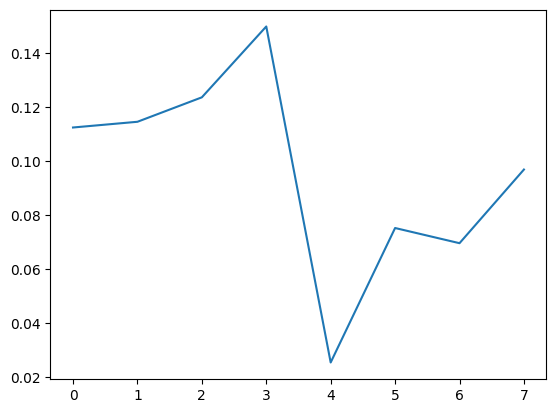

[PPO] Epoch 0: Loss=12.0742, Policy=0.0221, Value=24.1344
[PPO] Epoch 10: Loss=5.8584, Policy=0.0236, Value=11.6995
[PPO] Epoch 20: Loss=2.9851, Policy=0.0104, Value=5.9797
[PPO] Epoch 30: Loss=1.3546, Policy=-0.0115, Value=2.7627
[PPO] Epoch 40: Loss=1.3944, Policy=-0.0374, Value=2.8948
[PPO] Epoch 50: Loss=0.4153, Policy=-0.0570, Value=0.9755
[PPO] Epoch 60: Loss=0.1706, Policy=-0.0800, Value=0.5302
[PPO] Epoch 70: Loss=0.1770, Policy=-0.0862, Value=0.5552
[PPO] Epoch 80: Loss=0.1047, Policy=-0.0993, Value=0.4370
[PPO] Epoch 90: Loss=0.1385, Policy=-0.0751, Value=0.4529
Approx KL Learned: 0.07761117070913315
Update 2/10 — steps: 1024


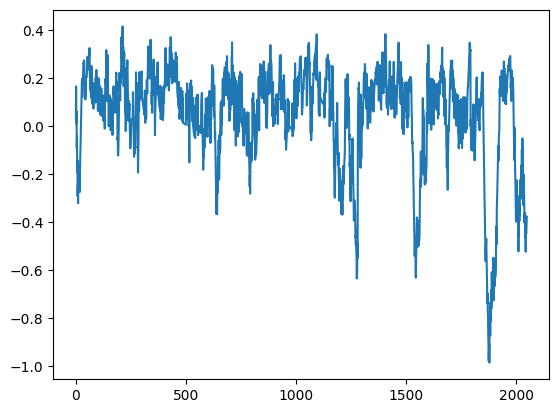

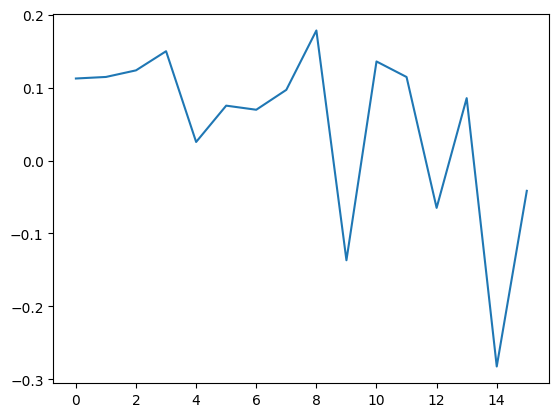

[PPO] Epoch 0: Loss=2.4242, Policy=0.0270, Value=4.8247
[PPO] Epoch 10: Loss=0.6578, Policy=-0.0162, Value=1.3777
[PPO] Epoch 20: Loss=0.2129, Policy=-0.0609, Value=0.5777
[PPO] Epoch 30: Loss=0.0331, Policy=-0.0882, Value=0.2719
[PPO] Epoch 40: Loss=-0.0082, Policy=-0.1050, Value=0.2226
[PPO] Epoch 50: Loss=-0.0628, Policy=-0.1153, Value=0.1328
[PPO] Epoch 60: Loss=-0.0550, Policy=-0.1257, Value=0.1694
[PPO] Epoch 70: Loss=-0.0922, Policy=-0.1300, Value=0.1032
[PPO] Epoch 80: Loss=-0.1051, Policy=-0.1328, Value=0.0829
[PPO] Epoch 90: Loss=-0.0909, Policy=-0.1340, Value=0.1134
Approx KL Learned: 0.10161039233207703
Update 3/10 — steps: 1024


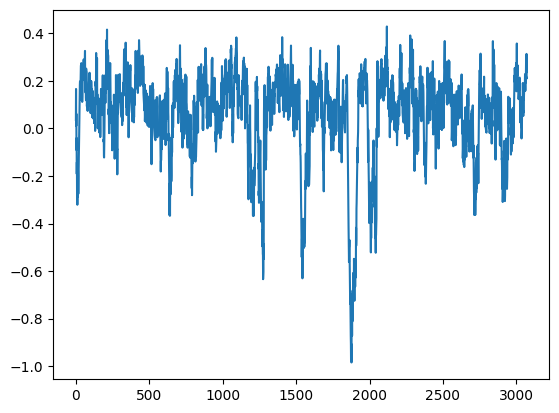

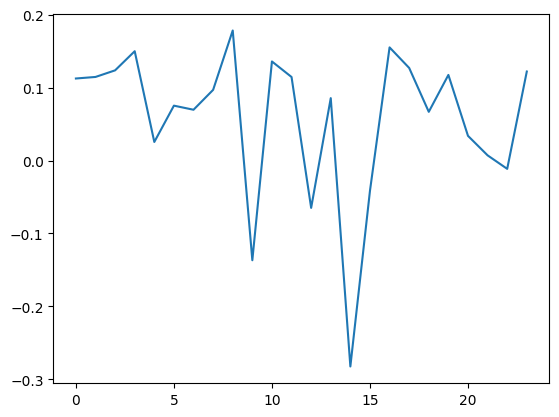

[PPO] Epoch 0: Loss=18.9210, Policy=0.0047, Value=37.8591
[PPO] Epoch 10: Loss=9.0605, Policy=0.0232, Value=18.1022
[PPO] Epoch 20: Loss=3.9055, Policy=-0.0074, Value=7.8528
[PPO] Epoch 30: Loss=1.2602, Policy=-0.0091, Value=2.5652
[PPO] Epoch 40: Loss=0.6229, Policy=-0.0422, Value=1.3576
[PPO] Epoch 50: Loss=0.2902, Policy=-0.0590, Value=0.7247
[PPO] Epoch 60: Loss=0.2087, Policy=-0.0732, Value=0.5899
[PPO] Epoch 70: Loss=0.2128, Policy=-0.0795, Value=0.6103
[PPO] Epoch 80: Loss=0.0872, Policy=-0.0930, Value=0.3857
[PPO] Epoch 90: Loss=0.0556, Policy=-0.0999, Value=0.3357
Approx KL Learned: 0.07021254301071167
Update 4/10 — steps: 1024


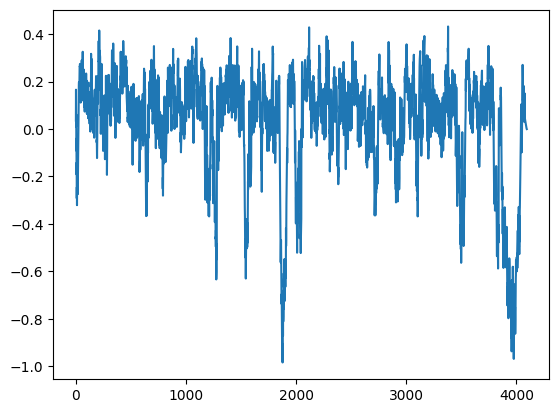

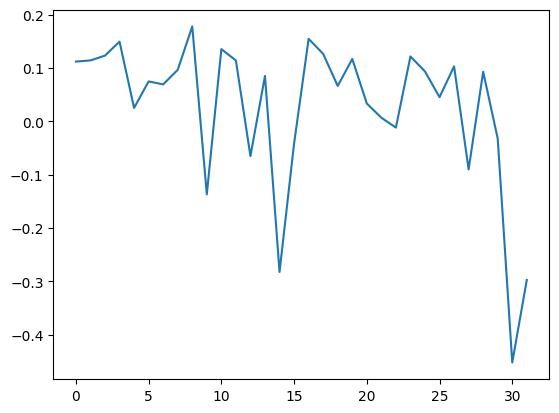

[PPO] Epoch 0: Loss=4.3842, Policy=0.0238, Value=8.7483
[PPO] Epoch 10: Loss=1.1913, Policy=0.0085, Value=2.3932
[PPO] Epoch 20: Loss=0.3813, Policy=-0.0240, Value=0.8392
[PPO] Epoch 30: Loss=0.1824, Policy=-0.0461, Value=0.4847
[PPO] Epoch 40: Loss=0.0978, Policy=-0.0615, Value=0.3452
[PPO] Epoch 50: Loss=0.0201, Policy=-0.0775, Value=0.2216
[PPO] Epoch 60: Loss=0.0147, Policy=-0.0887, Value=0.2332
[PPO] Epoch 70: Loss=0.0207, Policy=-0.0937, Value=0.2552
[PPO] Epoch 80: Loss=-0.0280, Policy=-0.1008, Value=0.1718
[PPO] Epoch 90: Loss=-0.0321, Policy=-0.1028, Value=0.1676
Approx KL Learned: 0.09212048351764679
Update 5/10 — steps: 1024


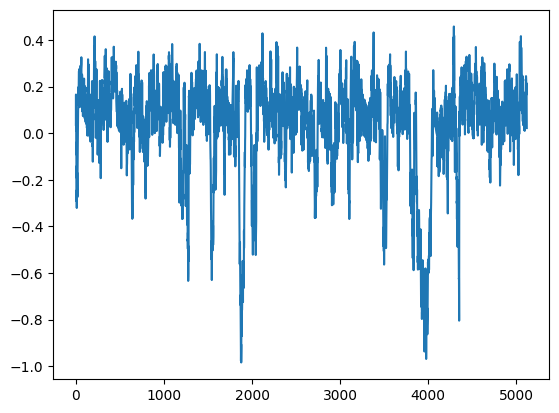

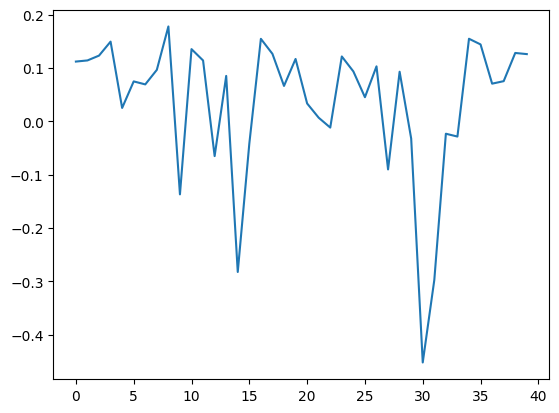

[PPO] Epoch 0: Loss=3.7799, Policy=0.0089, Value=7.5673
[PPO] Epoch 10: Loss=1.0809, Policy=-0.0219, Value=2.2316
[PPO] Epoch 20: Loss=0.3874, Policy=-0.0393, Value=0.8796
[PPO] Epoch 30: Loss=0.1744, Policy=-0.0651, Value=0.5043
[PPO] Epoch 40: Loss=0.0550, Policy=-0.0819, Value=0.2978
[PPO] Epoch 50: Loss=0.0125, Policy=-0.0870, Value=0.2228
[PPO] Epoch 60: Loss=0.0842, Policy=-0.0881, Value=0.3681
[PPO] Epoch 70: Loss=0.0353, Policy=-0.0957, Value=0.2851
[PPO] Epoch 80: Loss=-0.0278, Policy=-0.0998, Value=0.1674
[PPO] Epoch 90: Loss=0.0014, Policy=-0.1016, Value=0.2287
Approx KL Learned: 0.06852741539478302
Update 6/10 — steps: 1024


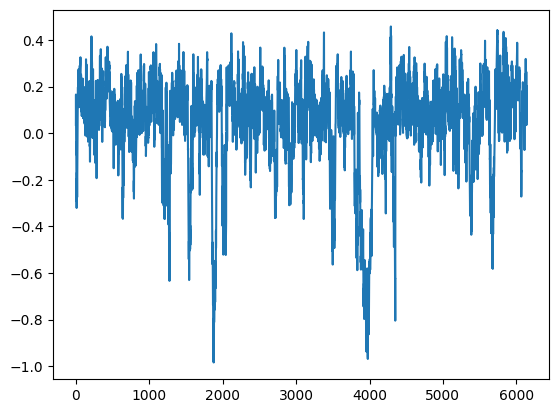

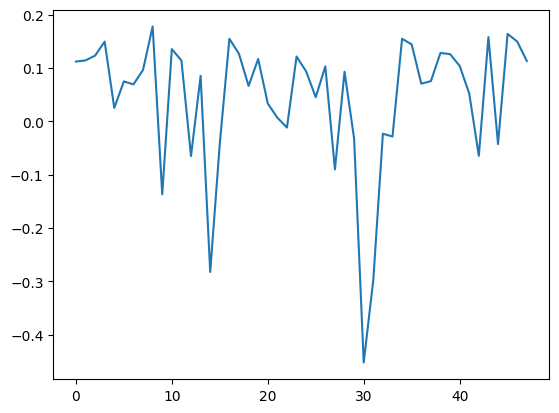

[PPO] Epoch 0: Loss=0.6670, Policy=0.0244, Value=1.3106
[PPO] Epoch 10: Loss=0.4733, Policy=-0.0217, Value=1.0148
[PPO] Epoch 20: Loss=0.1067, Policy=-0.0545, Value=0.3480
[PPO] Epoch 30: Loss=0.0386, Policy=-0.0672, Value=0.2359
[PPO] Epoch 40: Loss=-0.0287, Policy=-0.0936, Value=0.1551
[PPO] Epoch 50: Loss=-0.0498, Policy=-0.1059, Value=0.1364
[PPO] Epoch 60: Loss=-0.0253, Policy=-0.1120, Value=0.1978
[PPO] Epoch 70: Loss=-0.0622, Policy=-0.1097, Value=0.1198
[PPO] Epoch 80: Loss=-0.0560, Policy=-0.1229, Value=0.1575
[PPO] Epoch 90: Loss=-0.0936, Policy=-0.1252, Value=0.0872
Approx KL Learned: 0.23099187016487122
Update 7/10 — steps: 1024


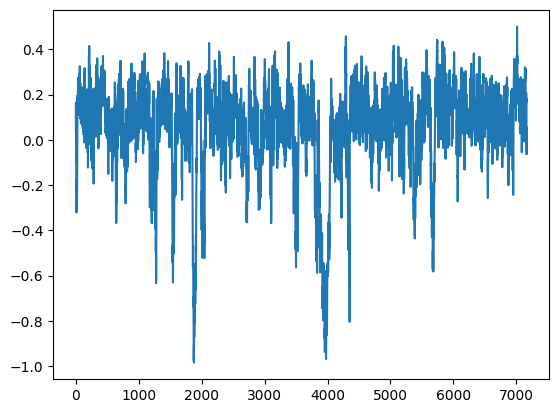

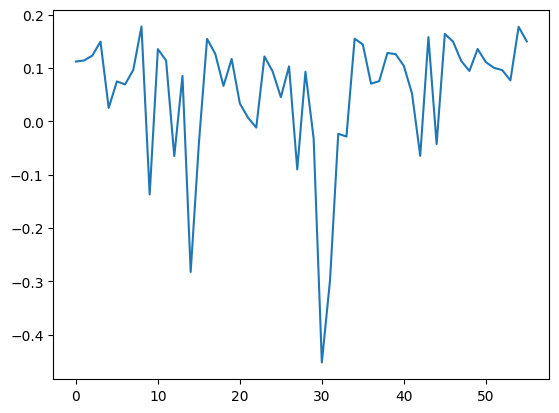

[PPO] Epoch 0: Loss=2.1864, Policy=0.0177, Value=4.3622
[PPO] Epoch 10: Loss=0.5227, Policy=-0.0224, Value=1.1163
[PPO] Epoch 20: Loss=0.1290, Policy=-0.0531, Value=0.3911
[PPO] Epoch 30: Loss=0.0554, Policy=-0.0790, Value=0.2954
[PPO] Epoch 40: Loss=0.0095, Policy=-0.0903, Value=0.2269
[PPO] Epoch 50: Loss=-0.0286, Policy=-0.0943, Value=0.1564
[PPO] Epoch 60: Loss=-0.0607, Policy=-0.1130, Value=0.1298
[PPO] Epoch 70: Loss=-0.0563, Policy=-0.1174, Value=0.1479
[PPO] Epoch 80: Loss=-0.0912, Policy=-0.1258, Value=0.0946
[PPO] Epoch 90: Loss=-0.0886, Policy=-0.1266, Value=0.1014
Approx KL Learned: 0.25121116638183594
Update 8/10 — steps: 1024


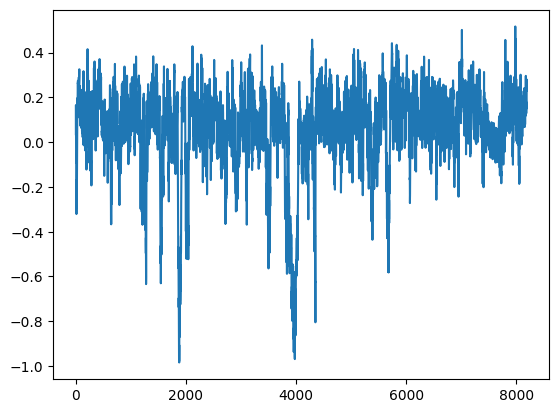

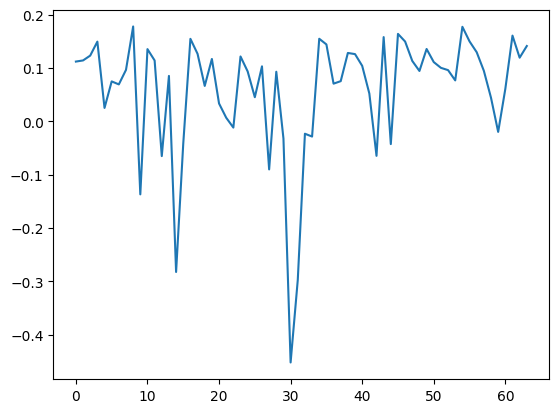

[PPO] Epoch 0: Loss=1.3224, Policy=0.0210, Value=2.6233
[PPO] Epoch 10: Loss=0.2943, Policy=-0.0293, Value=0.6687
[PPO] Epoch 20: Loss=0.0868, Policy=-0.0568, Value=0.3097
[PPO] Epoch 30: Loss=0.0579, Policy=-0.0757, Value=0.2889
[PPO] Epoch 40: Loss=-0.0016, Policy=-0.0848, Value=0.1882
[PPO] Epoch 50: Loss=-0.0366, Policy=-0.0954, Value=0.1392
[PPO] Epoch 60: Loss=-0.0533, Policy=-0.0981, Value=0.1115
[PPO] Epoch 70: Loss=-0.0436, Policy=-0.0998, Value=0.1344
[PPO] Epoch 80: Loss=-0.0571, Policy=-0.1030, Value=0.1148
[PPO] Epoch 90: Loss=-0.0778, Policy=-0.1047, Value=0.0765
Approx KL Learned: 0.2626286447048187
Update 9/10 — steps: 1024


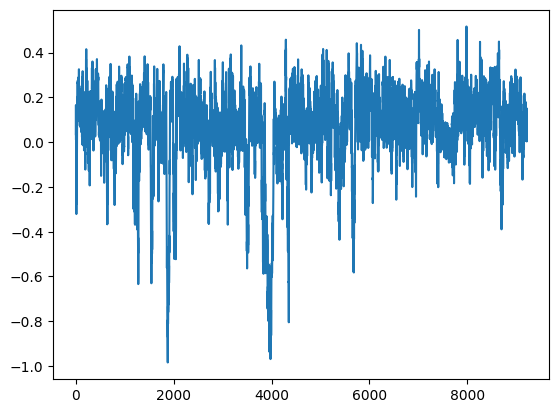

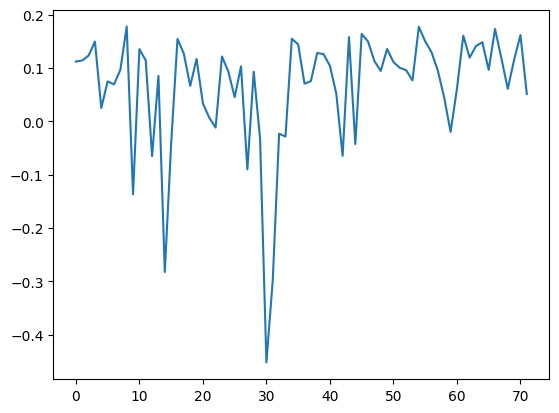

[PPO] Epoch 0: Loss=2.0918, Policy=0.0099, Value=4.1858
[PPO] Epoch 10: Loss=0.5512, Policy=-0.0152, Value=1.1578
[PPO] Epoch 20: Loss=0.1760, Policy=-0.0410, Value=0.4567
[PPO] Epoch 30: Loss=0.0943, Policy=-0.0554, Value=0.3225
[PPO] Epoch 40: Loss=0.0341, Policy=-0.0676, Value=0.2258
[PPO] Epoch 50: Loss=-0.0061, Policy=-0.0757, Value=0.1619
[PPO] Epoch 60: Loss=-0.0218, Policy=-0.0811, Value=0.1410
[PPO] Epoch 70: Loss=-0.0311, Policy=-0.0860, Value=0.1317
[PPO] Epoch 80: Loss=-0.0407, Policy=-0.0894, Value=0.1191
[PPO] Epoch 90: Loss=-0.0437, Policy=-0.0900, Value=0.1146
Approx KL Learned: 0.10229700803756714
Update 10/10 — steps: 1024


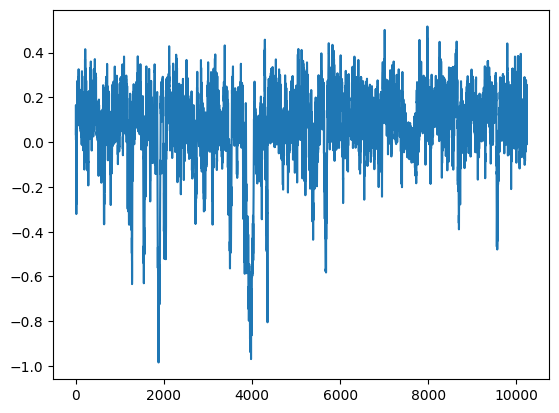

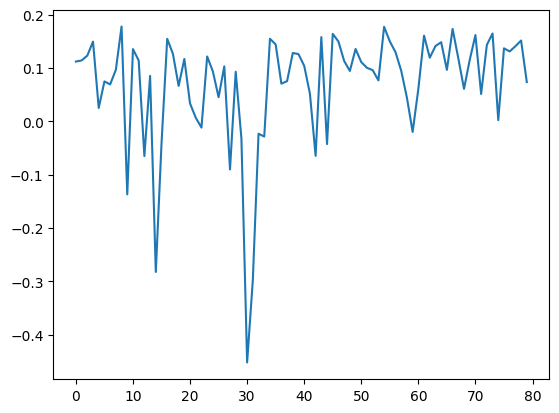

In [19]:
ENTROPY_COEF = 0.02
buf, rewards = train(controller, clip_env, clip_actor_critic, 10)

In [162]:
save_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_clip_embed.pt")

[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_clip_embed.pt


In [ ]:
house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [187]:
load_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_high_entropy.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from clip_actor_critic_checkpoint_high_entropy.pt


Init position {'x': 11.71670150756836, 'y': 0.9009993672370911, 'z': 9.2752685546875}


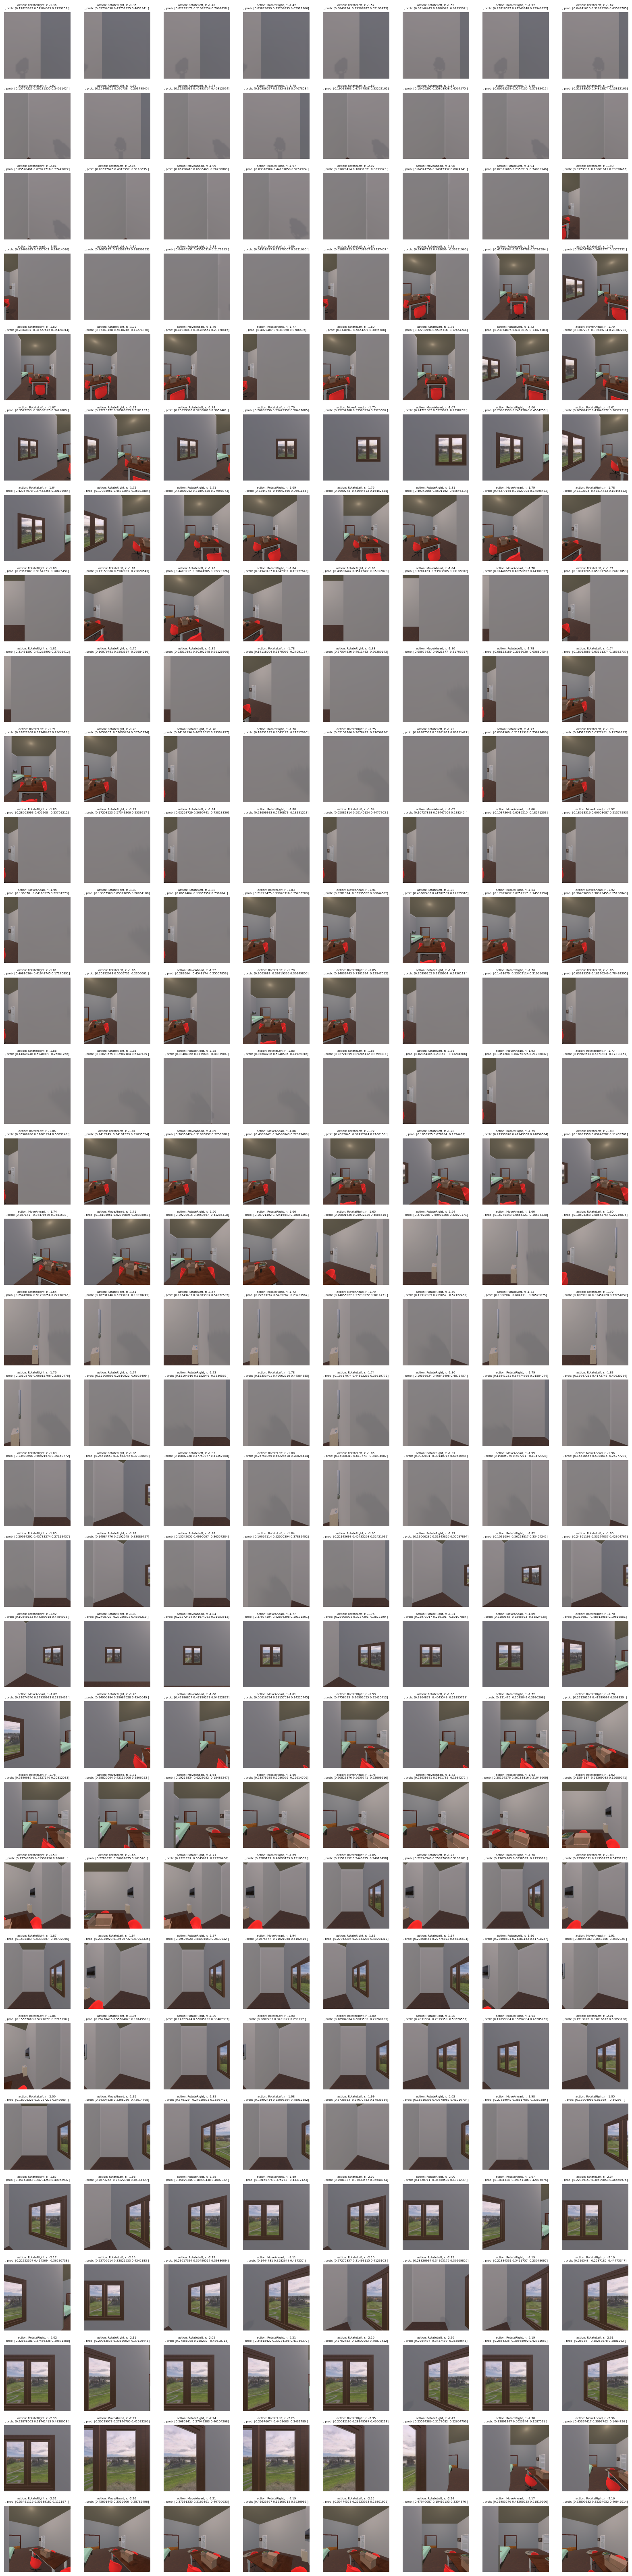

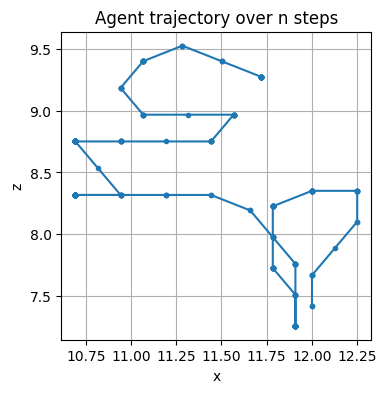

In [190]:
import matplotlib.pyplot as plt
import numpy as np

n = 256
n_row = 32
positions = []

plt.figure(figsize=(n // n_row * 2, n_row * 2))
# event = teleport(controller, {'x': 9.792665481567383, 'y': 0.9009993672370911, 'z': 2.9606857299804688})
event = teleport(controller)
print("Init position", event.metadata["agent"]["position"])
episode_seq = deque(maxlen=EPISODE_STEPS)
for t in range(1, n + 1):
    obs_t = obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(list(episode_seq) + [obs_t], dim=0).unsqueeze(0)
    logits, value = act_and_value(obs_seq, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0,4)

    event, reward = clip_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metada
    # ta
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob: " + str(torch.softmax(logits, dim=0).cpu().numpy()), fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


In [948]:
novelty.reset()

img_buffer = []

tensor([0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.1206,
        0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.2642], device='cuda:0'

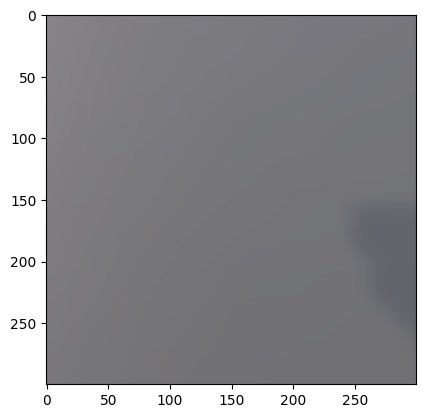

In [1075]:
# teleport(controller, {'x': 8.790684700012207, 'y': 0.9009993672370911, 'z': 2.460493564605713})

action_idx = 2
event = controller.step("RotateRight")

plt.imshow(event.frame)

novelty = clip_env.clip_novelty


frame_np = event.frame
# action_idx = np.random.randint(0,4)
img = Image.fromarray(frame_np)
img_t = novelty.preprocess(img).unsqueeze(0).to(novelty.device)
emb = novelty.model.encode_image(img_t)
emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize to unit sphere
if len(novelty.buffer) == 0:
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
else:
#     return 0.0  # no past frames to compare yet
    past = torch.cat(list(novelty.buffer), dim=0)  # (N, D)
    sim = F.cosine_similarity(emb, past)        # (N,)
    print((1 - sim), 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    reward = torch.mean((1 - sim) - 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
    print(sim)
    print(reward)

In [ ]:
Wall vs wall 0.9614


(<matplotlib.collections.PathCollection at 0x7fe3d001b550>,
 tensor(0.0137, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7705, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

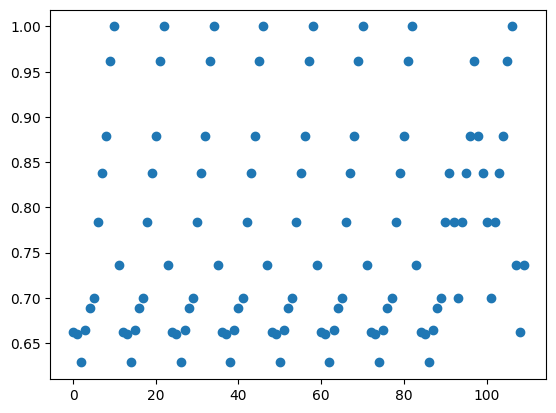

In [1076]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

(<matplotlib.collections.PathCollection at 0x7fe5487c1490>,
 tensor(0.0191, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7900, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

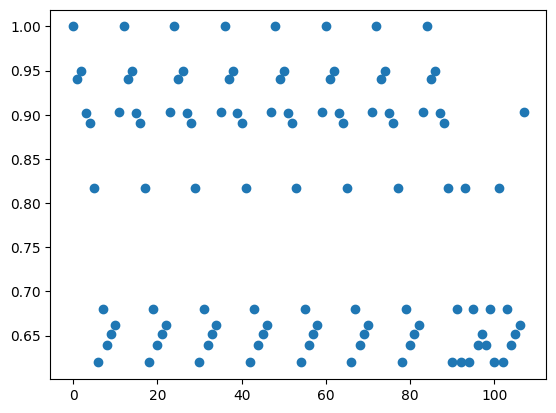

In [1073]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

In [17]:
controller.stop()